# 코퍼스 구축하기

이번 실습에서는 10개의 문장을 따로 지정하여 학습해보겠습니다. 

In [0]:
corpus = ['king is a strong man', 
          'queen is a wise woman', 
          'boy is a young man',
          'girl is a young woman',
          'prince is a young king',
          'princess is a young queen',
          'man is strong', 
          'woman is pretty',
          'prince is a boy will be king',
          'princess is a girl will be queen']

# stop words 제거하기

단어 벡터 사이의 유사성을 포착하기 위해 불용어(stop words)를 제거하겠습니다. 

\# from nltk.corpus import stopwords
위의 라이브러리에 내장된 목록을 사용할수도 있습니다. 

In [0]:
def remove_stop_words(corpus):
    stop_words = ['is', 'a', 'will', 'be']
    results = []
    for text in corpus:
        tmp = text.split(' ')
        for stop_word in stop_words:
            if stop_word in tmp:
                tmp.remove(stop_word)
        results.append(" ".join(tmp))
    
    return results

In [0]:
corpus = remove_stop_words(corpus)

In [0]:
words = []
for text in corpus:
    for word in text.split(' '):
        words.append(word)

words = set(words)

# Data generation

skip-gram의 학습을 위한 데이터 쌍을 만들겠습니다. 

In [0]:
word2int = {}

for i,word in enumerate(words):
    word2int[word] = i

sentences = []
for sentence in corpus:
    sentences.append(sentence.split())
    
WINDOW_SIZE = 2

data = []
for sentence in sentences:
    for idx, word in enumerate(sentence):
        for neighbor in sentence[max(idx - WINDOW_SIZE, 0) : min(idx + WINDOW_SIZE, len(sentence)) + 1] : 
            if neighbor != word:
                data.append([word, neighbor])

In [0]:
import pandas as pd
for text in corpus:
    print(text)

df = pd.DataFrame(data, columns = ['input', 'label'])

king strong man
queen wise woman
boy young man
girl young woman
prince young king
princess young queen
man strong
woman pretty
prince boy king
princess girl queen


In [0]:
df.head(10)

,input,label
0,king,strong
1,king,man
2,strong,king
3,strong,man
4,man,king
5,man,strong
6,queen,wise
7,queen,woman
8,wise,queen
9,wise,woman


# Word2Vec 구조

In [0]:
import tensorflow as tf
import numpy as np

ONE_HOT_DIM = len(words)

# one-hot vector 생성하기
def to_one_hot_encoding(data_point_index):
    one_hot_encoding = np.zeros(ONE_HOT_DIM)
    one_hot_encoding[data_point_index] = 1
    return one_hot_encoding

X = [] # input word
Y = [] # target word

for x, y in zip(df['input'], df['label']):
    X.append(to_one_hot_encoding(word2int[ x ]))
    Y.append(to_one_hot_encoding(word2int[ y ]))

# numpy array로 변환하기
X_train = np.asarray(X)
Y_train = np.asarray(Y)

# placeholders 선언
x = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))
y_label = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))

# 2차원으로 임베딩
EMBEDDING_DIM = 2 

# hidden layer
W1 = tf.Variable(tf.random_normal([ONE_HOT_DIM, EMBEDDING_DIM]))
b1 = tf.Variable(tf.random_normal([1])) #bias
hidden_layer = tf.add(tf.matmul(x,W1), b1)

# output layer
W2 = tf.Variable(tf.random_normal([EMBEDDING_DIM, ONE_HOT_DIM]))
b2 = tf.Variable(tf.random_normal([1]))
prediction = tf.nn.softmax(tf.add( tf.matmul(hidden_layer, W2), b2))

# loss function: cross entropy
loss = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(prediction), axis=[1]))

# training operation
train_op = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

# Train

In [0]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init) 

iteration = 20000
for i in range(iteration):
    # input == X_train (one hot encoded word)
    # label == Y_train (one hot encoded neighbor word)
    sess.run(train_op, feed_dict={x: X_train, y_label: Y_train})
    if i % 3000 == 0:
        print('iteration '+str(i)+' loss is : ', sess.run(loss, feed_dict={x: X_train, y_label: Y_train}))

iteration 0 loss is :  3.1556234
iteration 3000 loss is :  1.7993232
iteration 6000 loss is :  1.7201225
iteration 9000 loss is :  1.6936804
iteration 12000 loss is :  1.6802709
iteration 15000 loss is :  1.6714159
iteration 18000 loss is :  1.66481


In [0]:
# hidden layer (W1 + b1)가 원하는 벡터
vectors = sess.run(W1 + b1)
print(vectors)

[[-0.49955606 -0.50823355]
 [-0.09531592  0.95151967]
 [-1.2229526   4.2072353 ]
 [ 1.1973398  -2.9596941 ]
 [ 0.38976115 -0.11932427]
 [-0.6923288  -0.76017594]
 [-4.7428203  -3.4331765 ]
 [-1.2154211   5.028115  ]
 [-0.20741756  0.9373924 ]
 [-1.60654    -0.9952768 ]
 [-2.393888   -4.0677056 ]
 [ 3.0096831   1.2325304 ]]


# word vector in table

In [0]:
w2v_df = pd.DataFrame(vectors, columns = ['x1', 'x2'])
w2v_df['word'] = words
w2v_df = w2v_df[['word', 'x1', 'x2']]
w2v_df

,word,x1,x2
0,queen,-0.499556,-0.508234
1,boy,-0.095316,0.951520
2,man,-1.222953,4.207235
3,pretty,1.197340,-2.959694
4,young,0.389761,-0.119324
5,girl,-0.692329,-0.760176
6,princess,-4.742820,-3.433177
7,prince,-1.215421,5.028115
8,king,-0.207418,0.937392
9,woman,-1.606540,-0.995277


# word vector in 2d chart

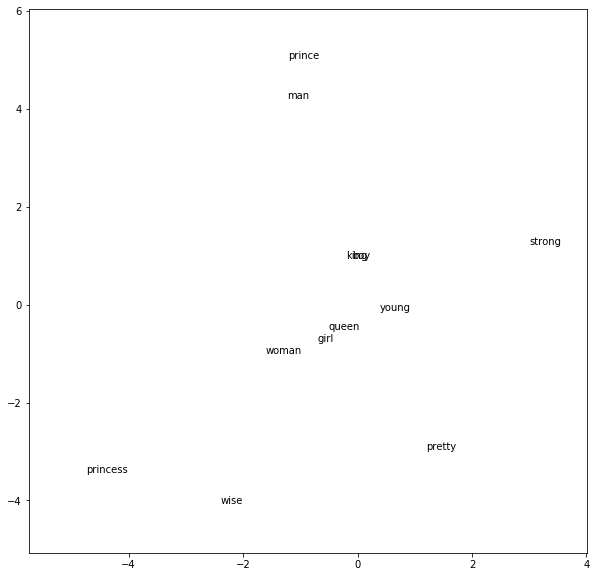

In [0]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for word, x1, x2 in zip(w2v_df['word'], w2v_df['x1'], w2v_df['x2']):
    ax.annotate(word, (x1,x2 ))
    
PADDING = 1.0
x_axis_min = np.amin(vectors, axis=0)[0] - PADDING
y_axis_min = np.amin(vectors, axis=0)[1] - PADDING
x_axis_max = np.amax(vectors, axis=0)[0] + PADDING
y_axis_max = np.amax(vectors, axis=0)[1] + PADDING
 
plt.xlim(x_axis_min,x_axis_max)
plt.ylim(y_axis_min,y_axis_max)
plt.rcParams["figure.figsize"] = (10,10)

plt.show()